In [5]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

'/home/nils/projects/uq-regression-box'

In [14]:
from uq_regression_box.datamodules import ToySineDatamodule
from uq_regression_box.models import MLP
from uq_regression_box.uq_methods import (
    BaseModel,
    CQR,
    MCDropoutModel,
    QuantileRegressionModel,
)

import matplotlib.pyplot as plt
import torch
import numpy as np

from uq_regression_box.viz_utils import (
    plot_toy_data,
    plot_predictions,
    plot_calibration_uq_toolbox,
)

from uq_regression_box.train_utils import basic_train_loop, NLL, QuantileLoss

from uq_regression_box.eval_utils import compute_empirical_coverage

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.rcParams["figure.figsize"] = [28, 9]

In [4]:
dm = ToySineDatamodule()
X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

X_test_cpu = torch.clone(X_test).numpy()
y_test_cpu = torch.clone(y_test).numpy()

# Base Model

In [5]:
config = {
    "model": {
        "model_name": "mlp",
    },
    "optimizer": {"lr": 1e-2},
}
model = BaseModel(config, MLP())

In [6]:
model = basic_train_loop(
    model, torch.nn.MSELoss(), train_loader, config["optimizer"]["lr"], n_epochs=1000
)

100%|██████████| 1000/1000 [00:12<00:00, 81.08it/s, loss=0.13152754306793213]


In [34]:
# get predictions
with torch.no_grad():
    y_preds_det = model(X_test)

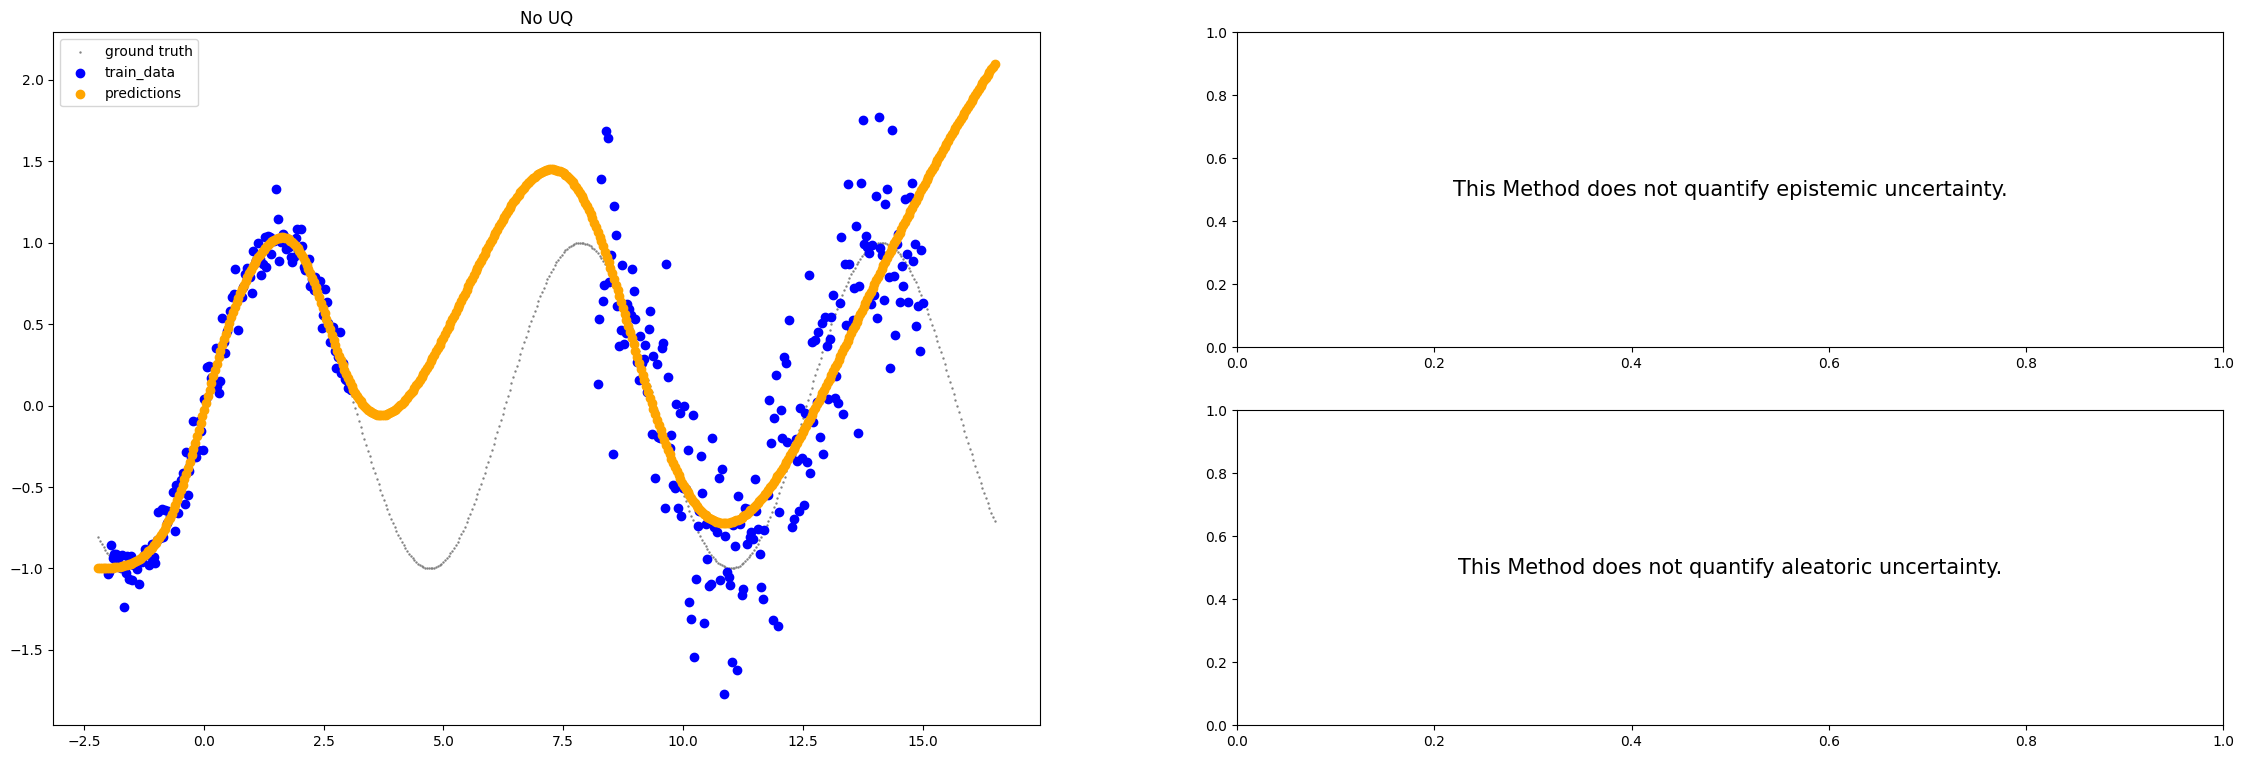

In [35]:
# plot predictions
plot_predictions(X_train, y_train, X_test_cpu, y_test_cpu, y_preds_det, title="No UQ")

# MC Dropout

In [7]:
config = {
    "model": {"model_name": "mlp", "mc-samples": 20},
    "optimizer": {"lr": 1e-2},
}
mc_droput_model = MCDropoutModel(
    config,
    MLP(n_outputs=2, dropout_p=0.1, n_hidden=[50, 50, 50], predict_sigma=True),
)

# train_model
basic_train_loop(mc_droput_model, NLL(), train_loader, lr=1e-2, n_epochs=1000)

# get predictions
with torch.no_grad():
    out = mc_droput_model.predict_step(X_test, y_test)
    mc_mean_nll = out["mean"]
    mc_std_nll = out["pred_uct"]
    mc_epistemic = out["epistemic_uct"]
    mc_aleatoric = out["aleatoric_uct"]

100%|██████████| 1000/1000 [00:11<00:00, 84.79it/s, loss=-1.6891831159591675]


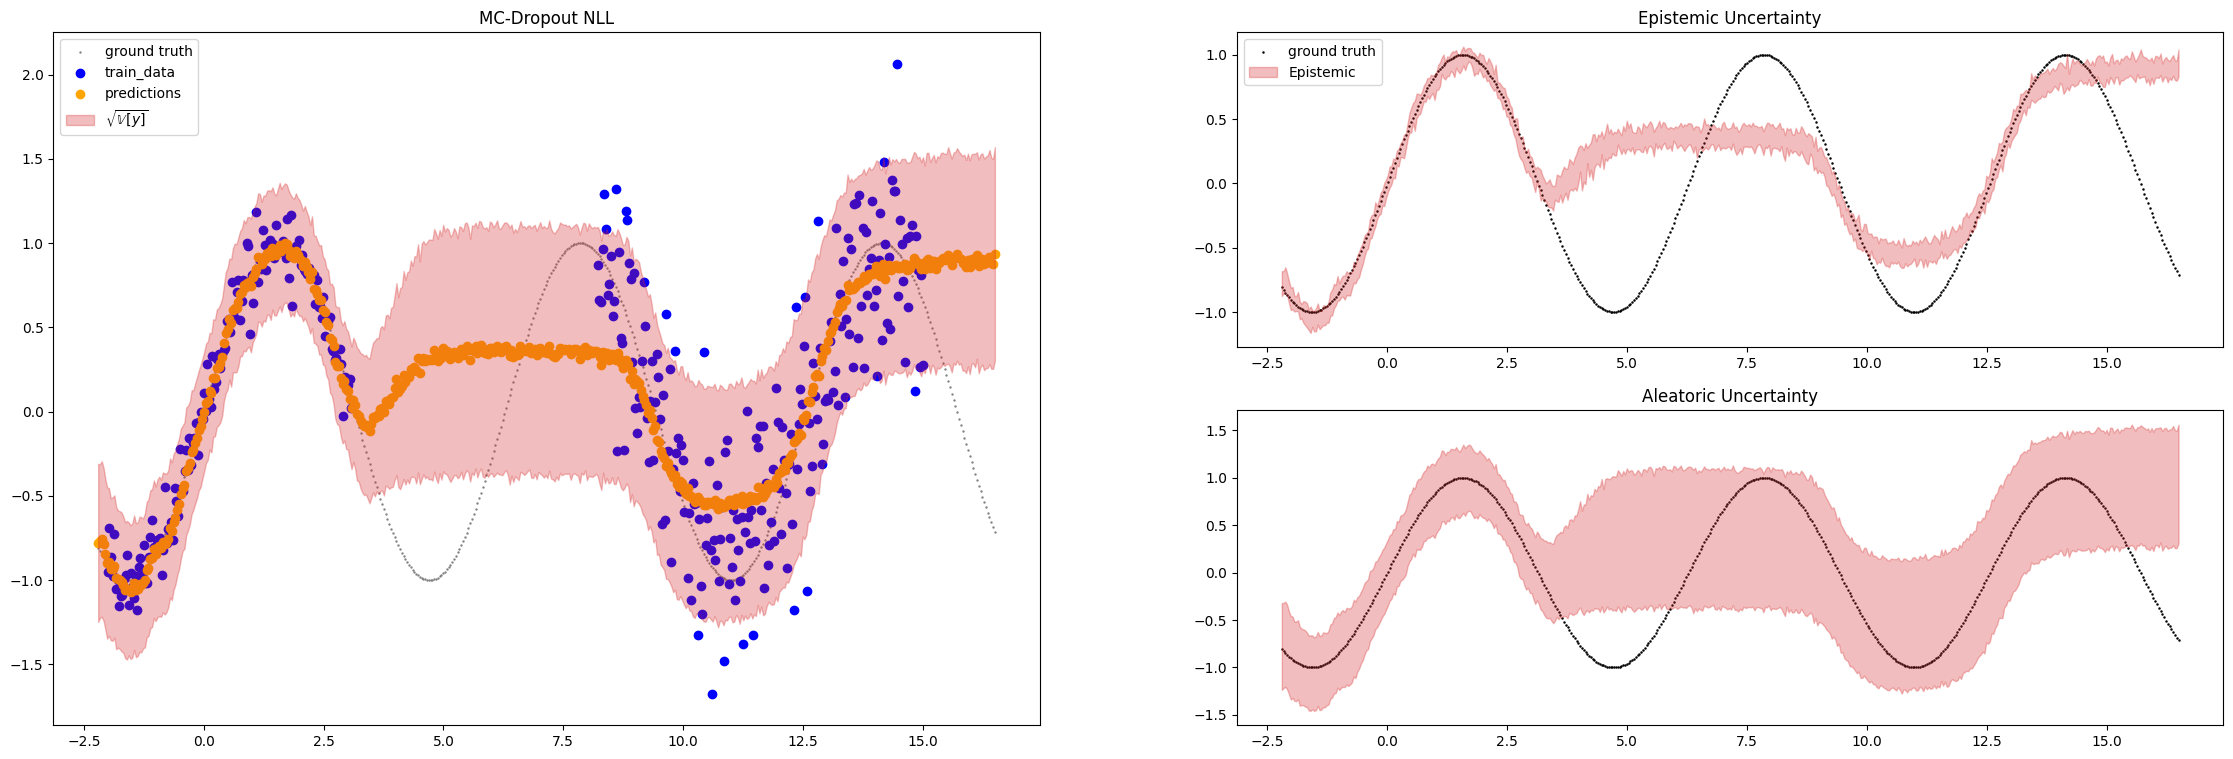

<Figure size 2800x900 with 0 Axes>

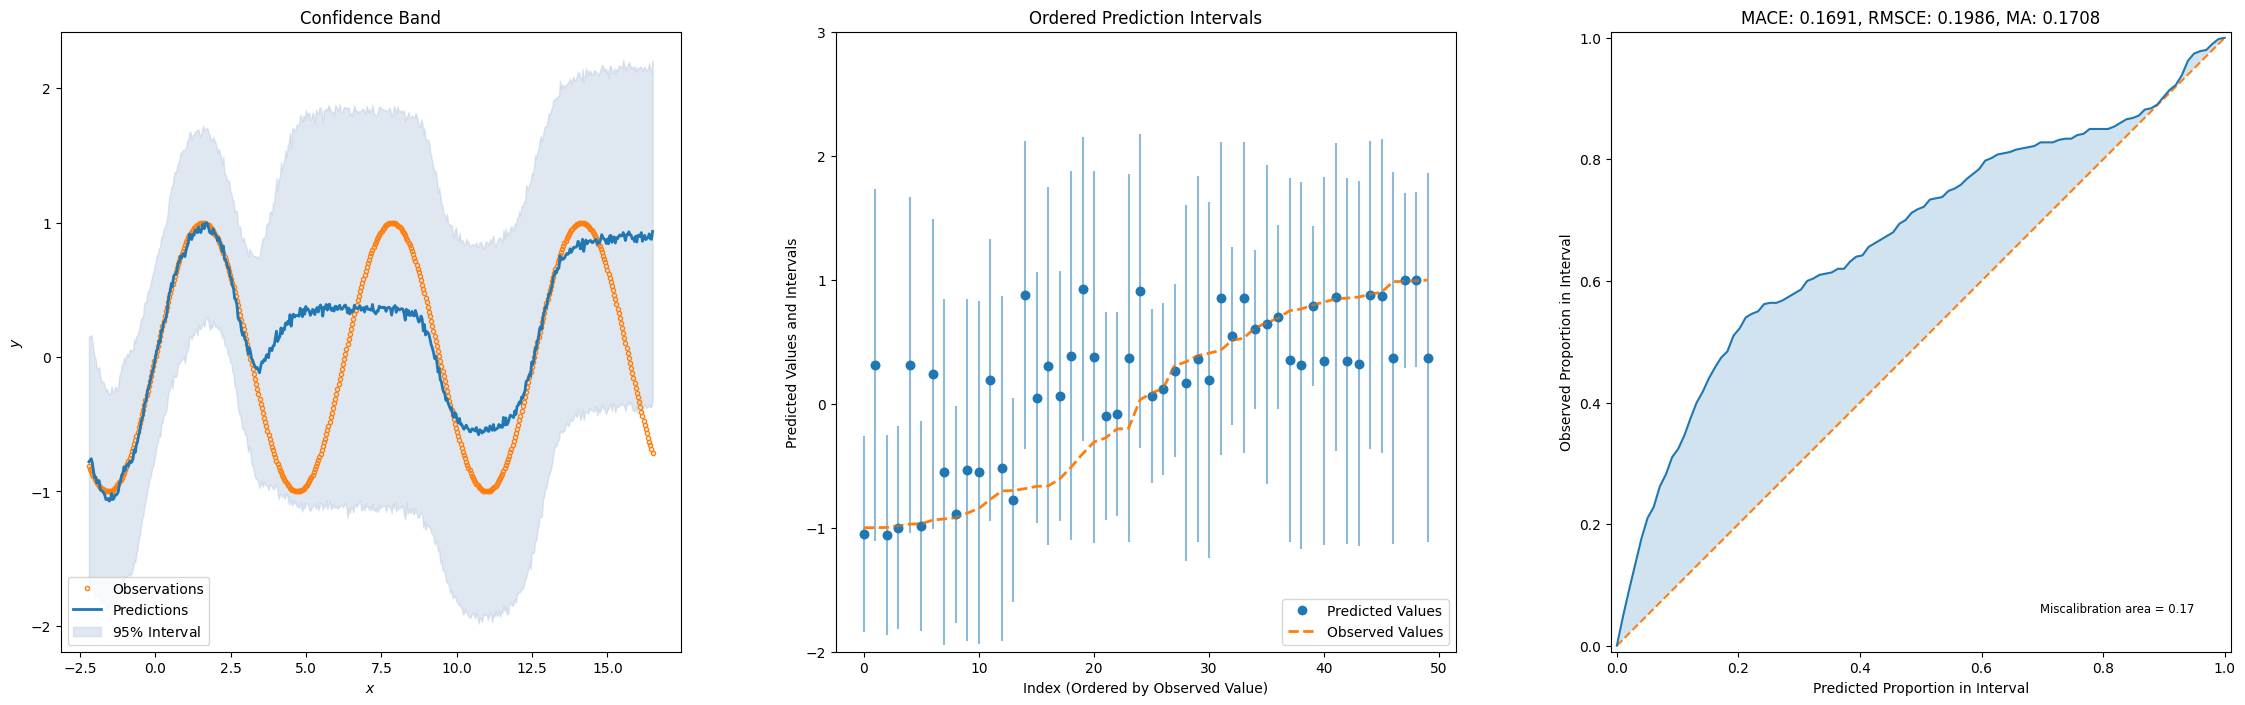

In [8]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    mc_mean_nll,
    mc_std_nll,
    epistemic=mc_epistemic,
    aleatoric=mc_aleatoric,
    title="MC-Dropout NLL",
)
plot_calibration_uq_toolbox(mc_mean_nll, mc_std_nll, y_test_cpu, X_test_cpu)

# Quantile Regression

In [9]:
quantiles = [0.1, 0.5, 0.9]
config = {
    "model": {"model_name": "mlp", "quantiles": quantiles},
    "optimizer": {"lr": 1e-2},
}

In [26]:
qr_model = QuantileRegressionModel(
    config, MLP(n_outputs=len(quantiles), n_hidden=[50, 50, 50])
)

# train_model
basic_train_loop(qr_model, qr_model.criterion, train_loader, lr=1e-2, n_epochs=1000)

# get predictions
with torch.no_grad():
    out = qr_model.predict_step(X_test, y_test)
    qr_mean = out["mean"]
    qr_median = out["median"]
    qr_std = out["pred_uct"]
    qr_aleatoric = out["aleatoric_uct"]
    quantile_preds = np.stack(
        [out["lower_quant"], qr_mean, out["upper_quant"]], axis=-1
    )

100%|██████████| 1000/1000 [00:11<00:00, 85.50it/s, loss=0.06648270040750504]


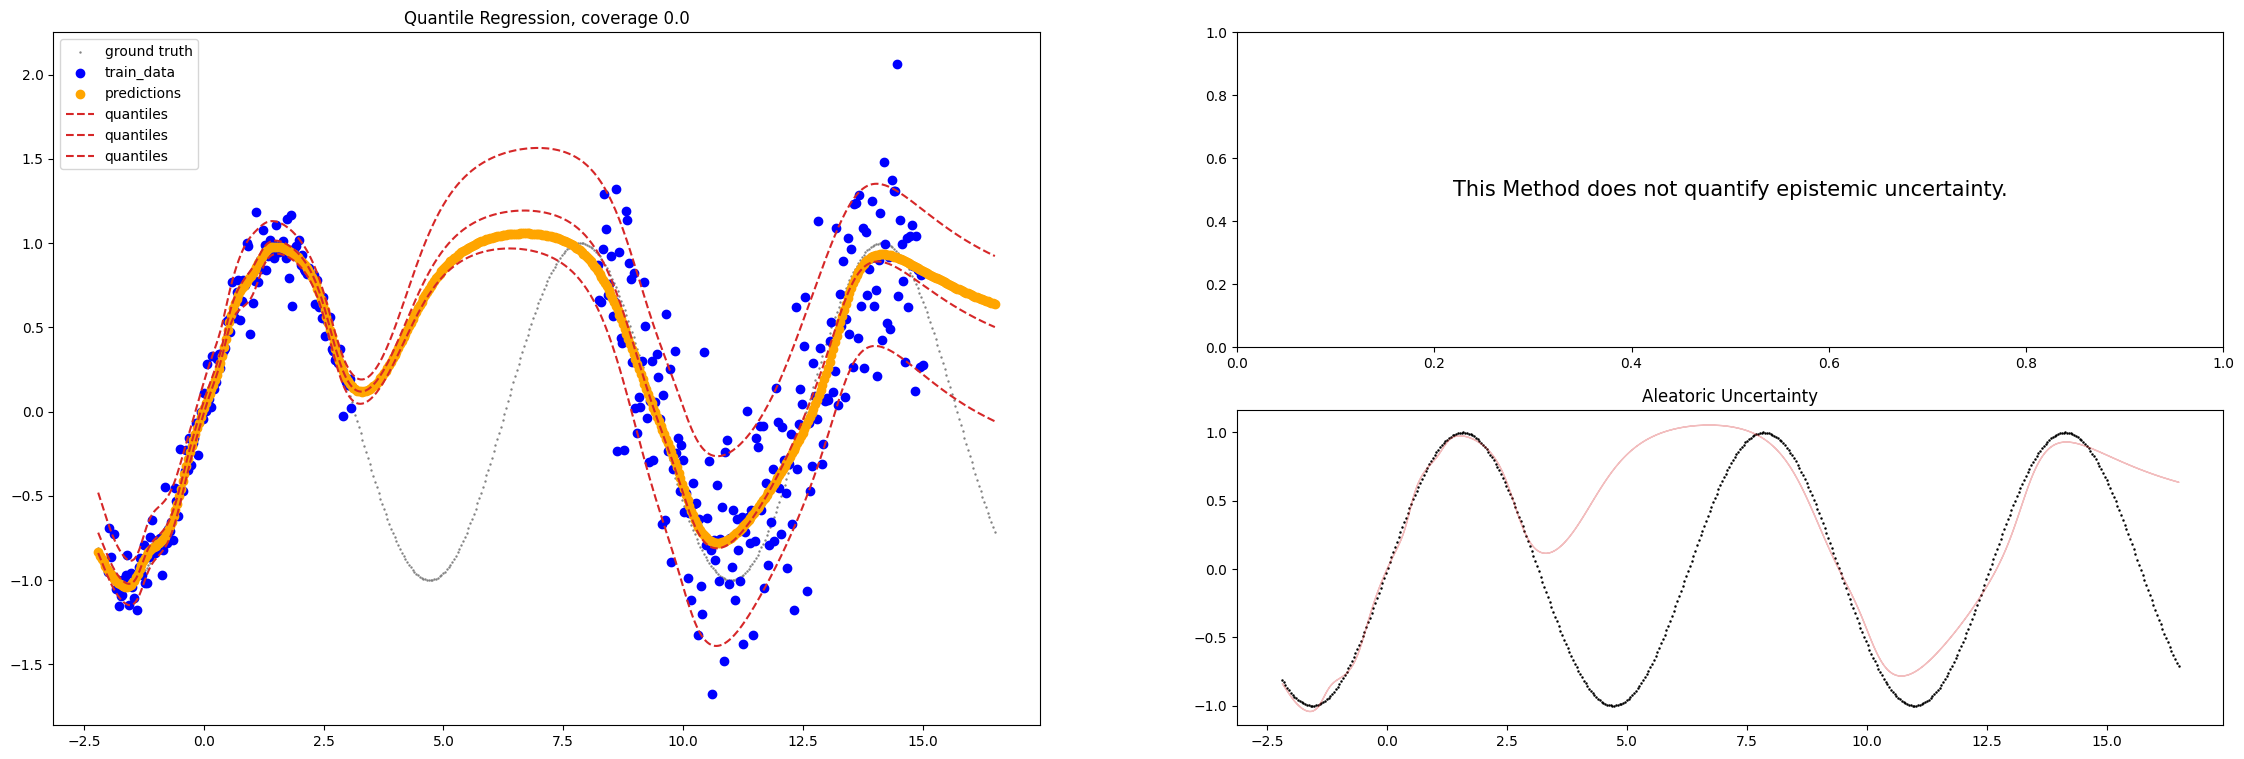

<Figure size 2800x900 with 0 Axes>

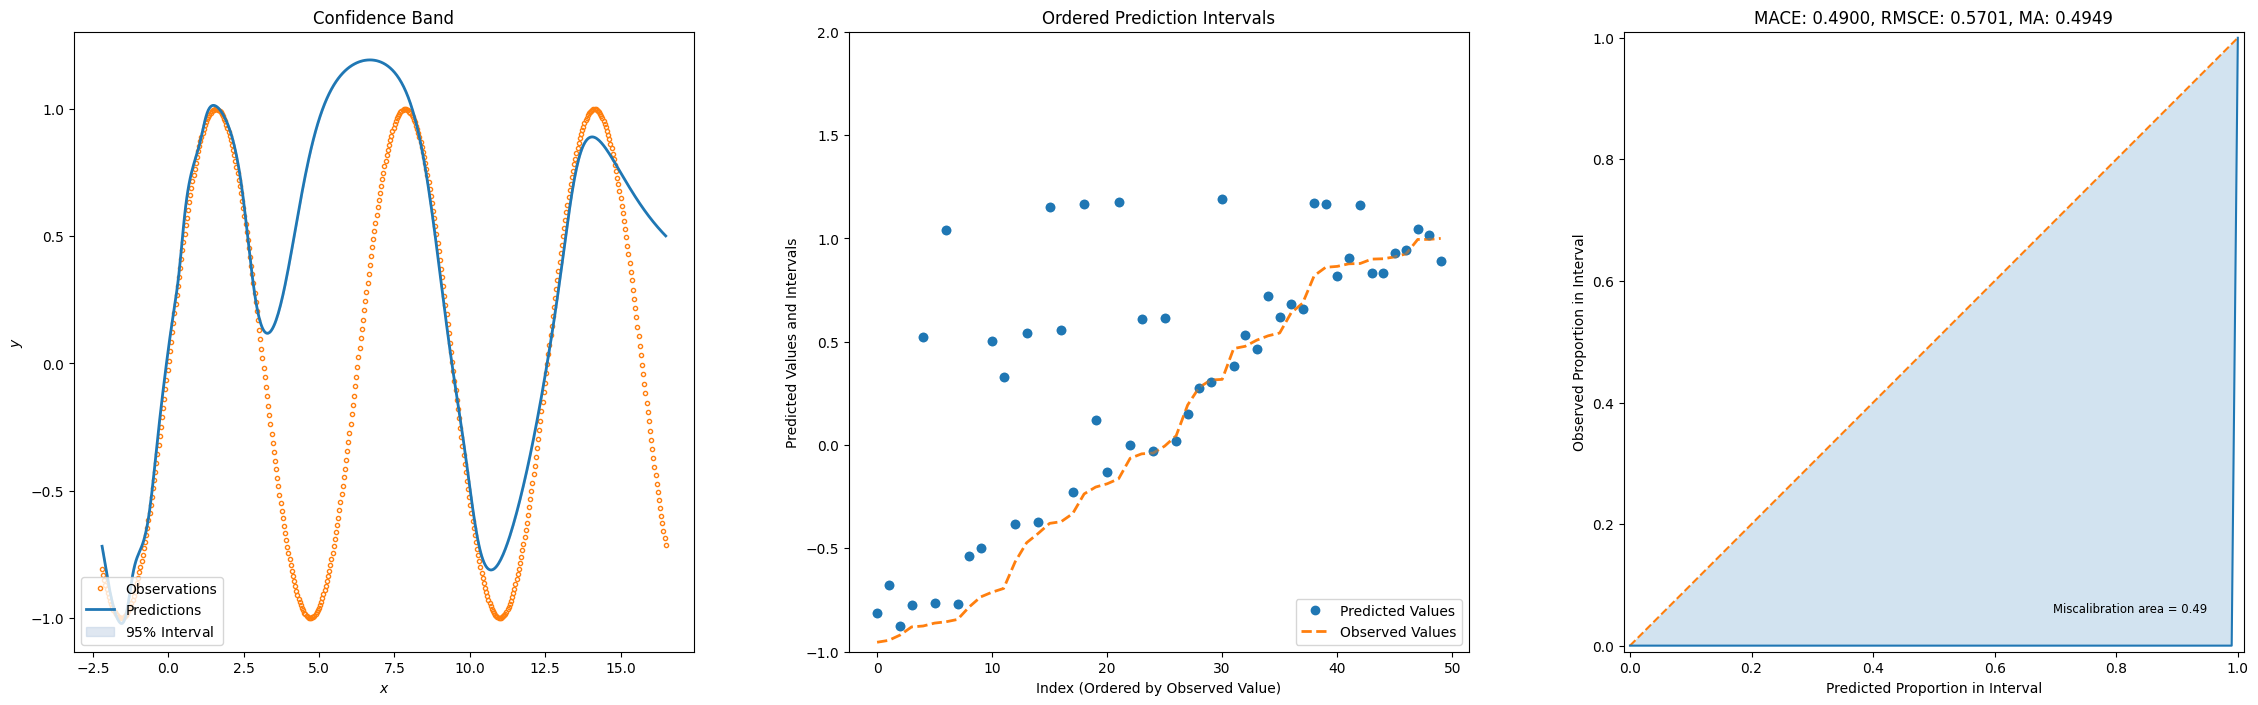

In [27]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    qr_median,
    pred_quantiles=quantile_preds,
    aleatoric=qr_aleatoric,
    title=f"Quantile Regression, coverage {compute_empirical_coverage(quantile_preds, y_test_cpu)}",
)
plot_calibration_uq_toolbox(qr_mean, qr_std, y_test_cpu, X_test_cpu)

# Conformalize Quantile Regression

In [40]:
cqr = CQR(qr_model.model, quantiles, test_loader)

# get predictions
with torch.no_grad():
    out = cqr.predict_step(X_test, y_test)
    cqr_mean = out["mean"]
    cqr_median = out["median"]
    cqr_std = out["pred_uct"]
    cqr_aleatoric = out["aleatoric_uct"]
    cqr_quantile_preds = np.stack(
        [out["lower_quant"], cqr_mean, out["upper_quant"]], axis=-1
    )

1.6810603


In [41]:
for key, item in out.items():
    print(key, item.shape)

mean (500,)
median (500,)
pred_uct (500,)
lower_quant (500,)
upper_quant (500,)
aleatoric_uct (500,)


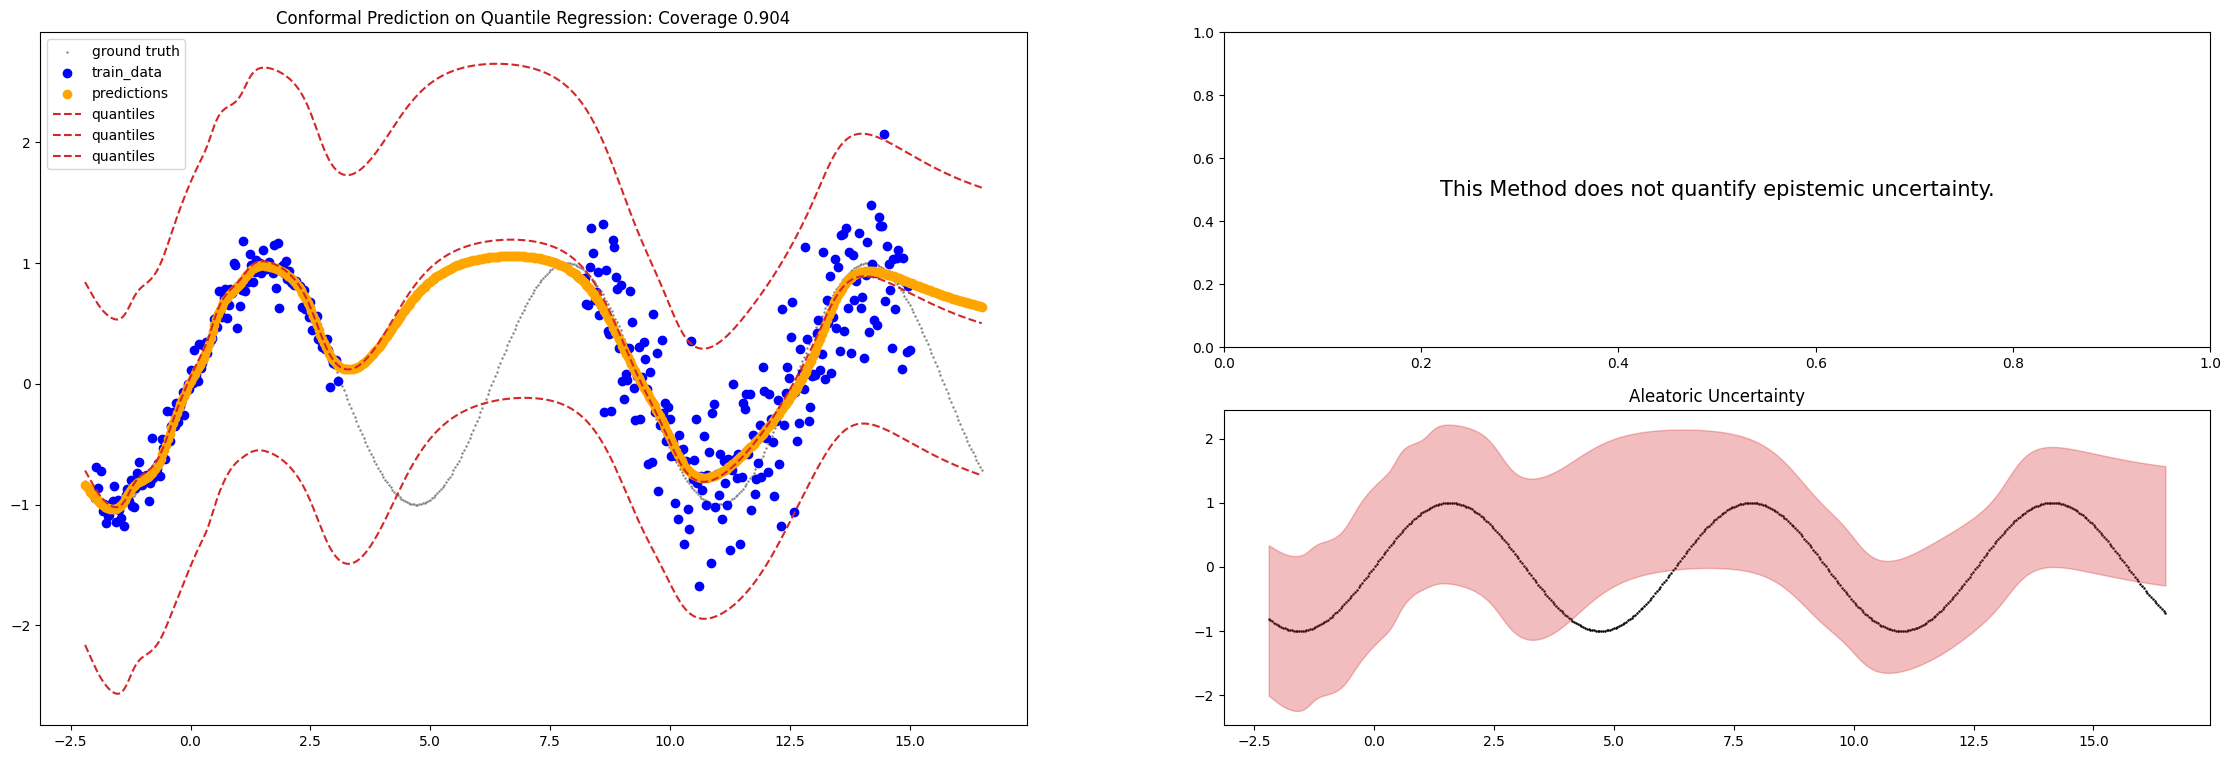

<Figure size 2800x900 with 0 Axes>

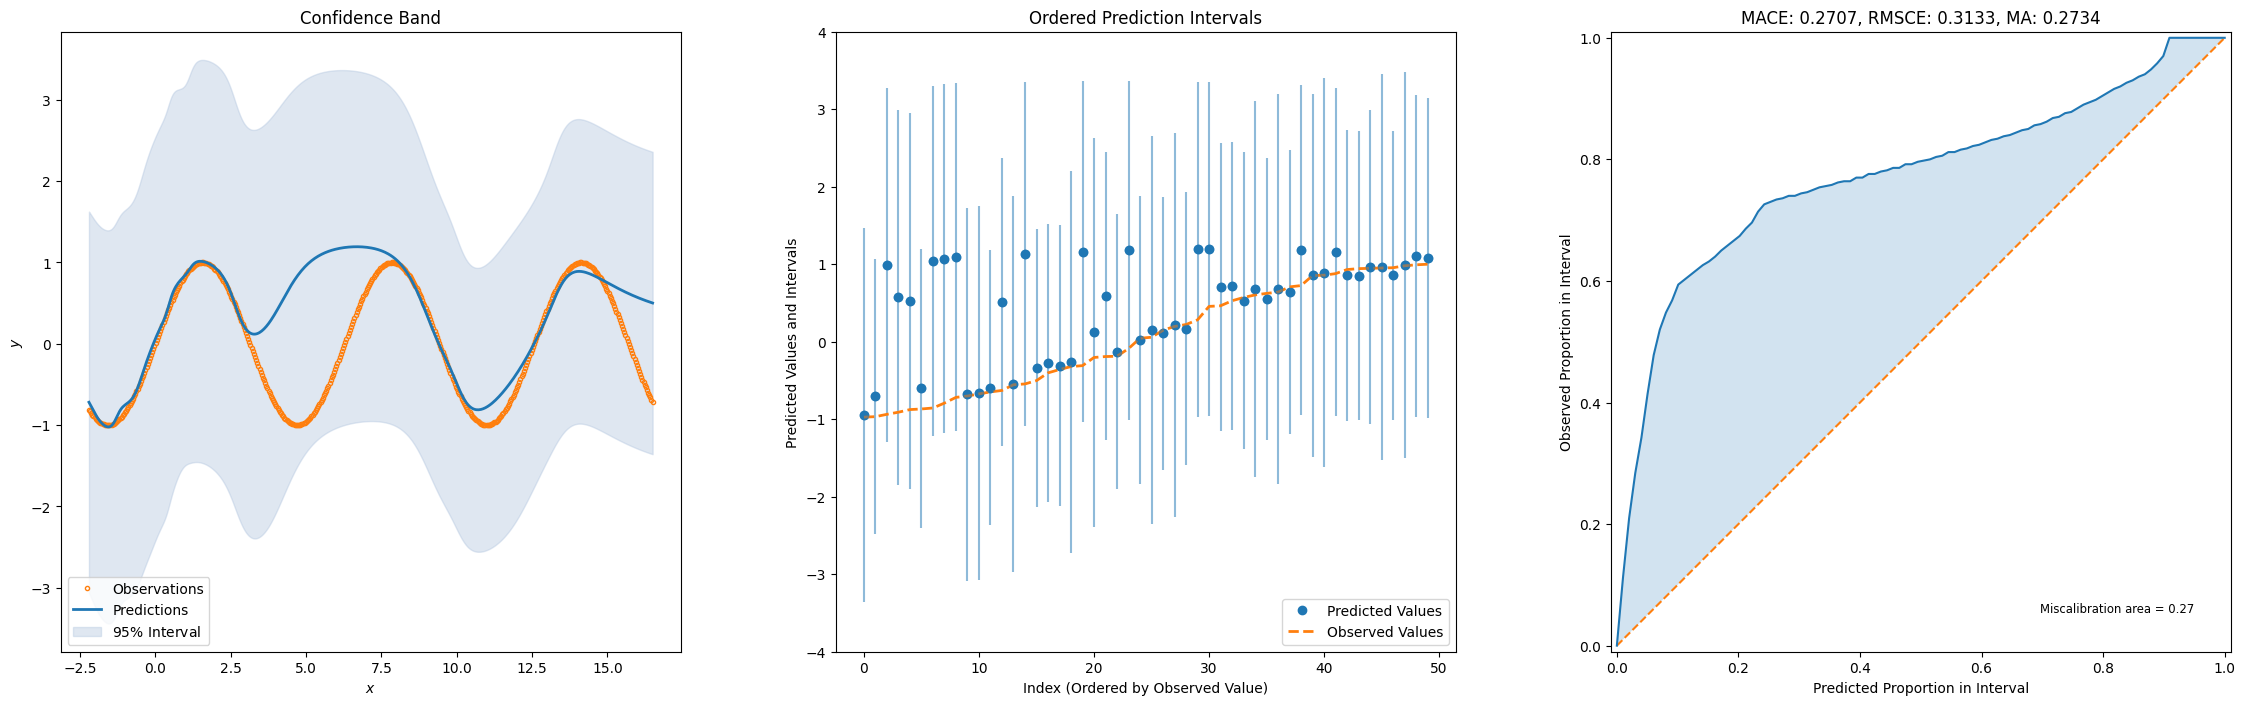

In [42]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    cqr_median,
    pred_quantiles=cqr_quantile_preds,
    aleatoric=cqr_aleatoric,
    title=f"Conformal Prediction on Quantile Regression: Coverage {compute_empirical_coverage(cqr_quantile_preds, y_test_cpu)}",
)
plot_calibration_uq_toolbox(cqr_mean, cqr_std, y_test_cpu, X_test_cpu)